In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
from src.utils.data import read_fasta
from src.data.datasets import ProteinDataset
import numpy as np
from src.utils.data import read_pickle, save_to_pickle
from src.utils.evaluation import metrics_per_label_df
from torchmetrics.classification import AveragePrecision,Specificity
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from src.utils.losses import FocalLoss
from src.utils.evaluation import EvalMetrics


/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.utils.data import read_pickle, save_to_pickle


In [5]:
zs = read_fasta("../data/zero_shot/SwissProt_2023_unseen_sequences_and_labels.fasta")

In [24]:
embeddings_idx = torch.load('../data/embeddings/frozen_BioGPT_label_embeddings_mean_index.pt')
embeddings = torch.load('../data/embeddings/frozen_BioGPT_label_embeddings_mean.pt')
embeddings_idx[embeddings_idx.id.isin(set([j for i in zs for j in i[-1]]))]


,id,description_type,description,token_count
185244,GO:0000514,name,"3-sulfino-L-alanine: proton, glutamate antipor...",16
185245,GO:0000514,label,Enables the transfer of a solute or solutes fr...,83
185248,GO:0140439,name,protein-cysteine S-stearoyltransferase activity,8
185249,GO:0140439,label,Catalysis of the transfer of a stearoyl (syste...,60
185259,GO:0140517,name,protein-RNA adaptor activity,5
...,...,...,...,...
188643,GO:0140723,label,The chemical reactions and pathways resulting ...,34
188644,GO:0140723,synonym_exact,patulin anabolism,4
188645,GO:0140723,synonym_exact,patulin biosynthesis,3
188646,GO:0140723,synonym_exact,patulin formation,3


In [26]:
embeddings[embeddings_idx['id']=='GO:0140723'].mean()

tensor(-0.0115)

In [3]:
annotations_2023 = read_pickle('../data/annotations/go_annotations_2023_07_27.pkl')
annotations_2019 = read_pickle('../data/annotations/go_annotations_2019_07_01.pkl')
new_go_terms = set(annotations_2023.index) - set(annotations_2019.index)
annotations_2019_updated = pd.concat([annotations_2019,annotations_2023.loc[list(new_go_terms)]],axis=0)

In [6]:
annotations_2019.shape,annotations_2023.shape,annotations_2019_updated.shape

((47401, 7), (47595, 7), (48661, 7))

In [7]:
save_to_pickle(annotations_2019_updated,'../data/annotations/go_annotations_2019_07_01_updated.pkl')

,label,name,synonym_exact,synonym_narrow,synonym_related,synonym_broad,is_obsolete
GO:0000001,"The distribution of mitochondria, including th...",mitochondrion inheritance,[mitochondrial inheritance],[],[],[],NaN
GO:0000002,The maintenance of the structure and integrity...,mitochondrial genome maintenance,[],[],[],[],NaN
GO:0000003,The production of new individuals that contain...,reproduction,[reproductive physiological process],[],[],[],NaN
GO:0000005,OBSOLETE. Assists in the correct assembly of r...,obsolete ribosomal chaperone activity,[ribosomal chaperone activity],[],[],[],true
GO:0000006,Enables the transfer of zinc ions (Zn2+) from ...,high-affinity zinc transmembrane transporter a...,[high affinity zinc uptake transmembrane trans...,[],[high-affinity zinc uptake transmembrane trans...,[],NaN
...,...,...,...,...,...,...,...
GO:0140945,Catalysis of the reaction: L-lysyl4-+ S-adenos...,histone H3K4 monomethyltransferase activity,"[histone H3K4 monomethylase activity, histone ...",[],[],"[histone H4-K4 methylation, histone H4K4 methy...",NaN
GO:0140846,A process that activates or increases the freq...,positive regulation of promoter clearance from...,[],[],[],[],NaN
GO:0120220,The region in the apical portion of multicilia...,basal body patch,[centriolar patch],[],[],[],NaN
GO:0106420,Catalysis of the reaction: H2O + N6-biotinyl-L...,NAD-dependent protein biotinidase activity,[],[],[],[],NaN


In [2]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')
zero_shot = read_fasta('../data/swissprot/zero_shot/SwissProt_2023_unseen_sequences_and_labels.fasta')

In [7]:
train = [(k[0],j," ".join(k[1:]),'train') for j,k in train]
test = [(k[0],j," ".join(k[1:]),'val') for j,k in test]
val = [(k[0],j," ".join(k[1:]),'test') for j,k in val]
zero_shot = [(k[0],j," ".join(k[1:]),'zero_shot') for j,k in zero_shot]
df = train + val + test

In [8]:
df = pd.DataFrame(df,columns=['id','sequence','labels','split'])
df_zero_shot = pd.DataFrame(zero_shot,columns=['id','sequence','labels','split'])

In [121]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 522607


In [6]:
df.head()

,id,sequence,labels,split
0,P60545,MSKIIEYDETARRAIEAGVNTLADAVRVTLGPRGRHVVLAKAFGGP...,GO:0035639 GO:0032553 GO:0005524 GO:0017076 GO...,train
1,Q3KEX7,MKFSEQWLRGWVSPQVDRDALVARLSMAGLEVDSVTPAAGVFSGVV...,GO:0016070 GO:0035639 GO:0004812 GO:0032553 GO...,train
2,Q8D2U1,MKSVSIIDIIEKKIFKKKLVEINGWVRTKRNSKLGISFVDVYDGSC...,GO:0016070 GO:0004812 GO:0035639 GO:0032553 GO...,train
3,Q95KN1,MKPSLLVFTVYLLWLKDCHCAPTWKDKTDMHGNLKGFSEAGDIDVD...,GO:0044424 GO:0003674 GO:0044464 GO:0043226 GO...,train
4,Q98HL0,MNSLDLPGRPENTRIVVAMSGGVDSSVVAGLLKREGYDVVGVTLQL...,GO:0016070 GO:0035639 GO:0032553 GO:0005524 GO...,train


In [7]:
df['num_pos'] = df['labels'].str.split(' ').str.len()
df['num_pos'].describe()

count    522607.000000
mean         47.743901
std          38.433523
min           2.000000
25%          25.000000
50%          43.000000
75%          59.000000
max        1008.000000
Name: num_pos, dtype: float64

In [8]:
df['labels'].str.split(' ').apply(len).describe()

count    522607.000000
mean         47.743901
std          38.433523
min           2.000000
25%          25.000000
50%          43.000000
75%          59.000000
max        1008.000000
Name: labels, dtype: float64

In [5]:
df_zero_shot['labels'].str.split(' ').apply(len).describe()

count    894.000000
mean       1.139821
std        0.541164
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: labels, dtype: float64

In [9]:
labels_zero_shot = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df_zero_shot.iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels_zero_shot.update(row_labels.split(" "))

In [127]:
labels = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df[df['split']=='train'].iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels.update(row_labels.split(" "))

In [10]:
print('# GO Terms:',len(labels.keys()))

# GO Terms: 31365


In [11]:
print('GO Terms distribution')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

GO Terms distribution


count     31365.000000
mean        635.987821
std        7372.964658
min           1.000000
25%           4.000000
50%          14.000000
75%          70.000000
max      369909.000000
dtype: float64

In [12]:
go_term_distribution[go_term_distribution>0]

GO:0003674    369909
GO:0008150    346677
GO:0005575    321980
GO:0009987    295442
GO:0044464    291432
               ...  
GO:1903890         1
GO:0102632         1
GO:0010059         1
GO:0072616         1
GO:0030787         1
Length: 31365, dtype: int64

In [13]:
print('Sequence length distribution')

df['sequence'].apply(len).describe()

Sequence length distribution


count    522607.000000
mean        368.042215
std         334.721845
min           2.000000
25%         179.000000
50%         303.000000
75%         456.000000
max       35213.000000
Name: sequence, dtype: float64

In [14]:
df['sequence'].apply(len).quantile(.99)

1502.0

Zero shot

In [135]:
set(labels_zero_shot.keys()) & set(labels.keys())

set()

In [8]:
len(labels_zero_shot.keys())

228

In [16]:
annotations_2023.loc[list(labels_zero_shot.keys())]

,label,name,synonym_exact,synonym_narrow,synonym_related,synonym_broad
GO:0140404,A process mediated by a molecule secreted by a...,effector-mediated perturbation of host innate ...,[effector mediated modulation of host immune r...,[],[],[]
GO:0106290,Catalysis of the reaction: (E)-cinnamate + ATP...,trans-cinnamate-CoA ligase activity,[],[],[],[]
GO:0106286,Catalysis of the reaction: (E)-caffeate + ATP ...,(E)-caffeate-CoA ligase activity,[],[],[],[]
GO:0106411,Catalysis of the reaction: 5'XMP + H20 = phosp...,XMP 5'-nucleosidase activity,[],[],[],[]
GO:0140989,Catalysis of the reaction: 7-deoxyloganate + ...,7-deoxyloganate 7-hydroxylase activity,[],[],[],[]
...,...,...,...,...,...,...
GO:0106439,Enables the transfer of a solute or solutes fr...,L-lysine:L-arginine antiporter activity,[],[],[],[]
GO:0120258,The acetylation of peptidyl-threonine to form ...,peptidyl-threonine O-acetylation,[],[],[],[]
GO:0140450,The process of targeting specific proteins to ...,protein targeting to Golgi apparatus,[],[],[],[]
GO:0140882,The directed movement of zinc ions from a cell...,zinc export across plasma membrane,[zinc ion export from cell],[],[],[]


# Explore Model Predictions

In [15]:
#Read Val Datas
#final_validation_labels_fl_mlpscale2_projection_head_2layers

val_labels = pd.read_parquet("../outputs/results/final_validation_labels_FL_WeightedSampling_LargeMLP_LastToken.parquet")
val_logits = pd.read_parquet("../outputs/results/final_validation_logits_FL_WeightedSampling_LargeMLP_LastToken.parquet")
pinf_val_logits = pd.read_parquet('../outputs/results/validation_logits_proteinfer.parquet')
pinf_val_labels= pd.read_parquet('../outputs/results/validation_labels_proteinfer.parquet')
label_descriptions = pd.read_pickle('../data/annotations/go_annotations_2019_07_01.pkl')
label_descriptions['label'] = label_descriptions['label'].str.lower().str.rstrip()


In [16]:
val_labels.shape,pinf_val_logits.shape

((44362, 32102), (44300, 32102))

In [17]:
#Common ids.. They should all be common but there are 60 sequences more in our dataset
#Crate Tensor versions

common_seqids = list(set(val_labels.index) & set(pinf_val_labels.index))


val_logits = val_logits.loc[common_seqids]
val_labels = val_labels.loc[common_seqids]
pinf_val_logits = pinf_val_logits.loc[common_seqids]
pinf_val_labels = pinf_val_labels.loc[common_seqids]

val_logits_t = torch.tensor(val_logits.values)
val_labels_t = torch.tensor(val_labels.values).float()
val_probabilities_t = torch.sigmoid(val_logits_t)

pinf_val_logits_t = torch.tensor(pinf_val_logits.values)
pinf_val_labels_t = torch.tensor(pinf_val_labels.values).float()
pinf_val_probabilities_t = torch.sigmoid(pinf_val_logits_t)

val_probabilities = pd.DataFrame(val_probabilities_t.numpy(),columns=val_logits.columns,index=val_logits.index)
pinf_val_probabilities = pd.DataFrame(pinf_val_probabilities_t.numpy(),columns=pinf_val_logits.columns,index=pinf_val_logits.index)

In [18]:
# val_logits_t = torch.tensor(val_logits.values)
# val_labels_t = torch.tensor(val_labels.values).float()
# val_probabilities_t = torch.sigmoid(val_logits_t)

# pinf_val_logits_t = torch.tensor(pinf_val_logits.values)
# pinf_val_labels_t = torch.tensor(pinf_val_labels.values).float()
# pinf_val_probabilities_t = torch.sigmoid(pinf_val_logits_t)

# val_probabilities = pd.DataFrame(val_probabilities_t.numpy(),columns=val_logits.columns,index=val_logits.index)
# pinf_val_probabilities = pd.DataFrame(pinf_val_probabilities_t.numpy(),columns=pinf_val_logits.columns,index=pinf_val_logits.index)

In [ ]:
cooc = val_labels_t.T@val_labels_t

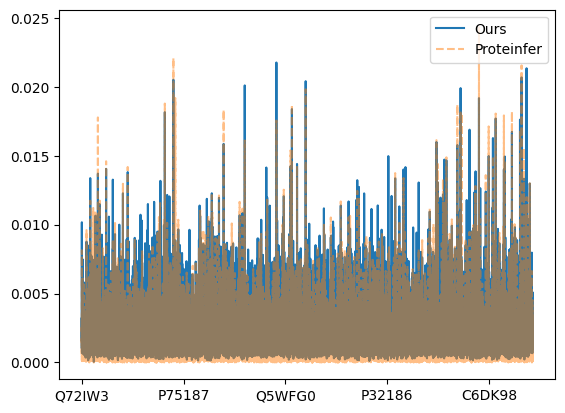

In [23]:
val_probabilities.mean(axis=1).plot(label='Ours')
pinf_val_probabilities.mean(axis=1).plot(label='Proteinfer',alpha=0.5,linestyle='--')
plt.legend()

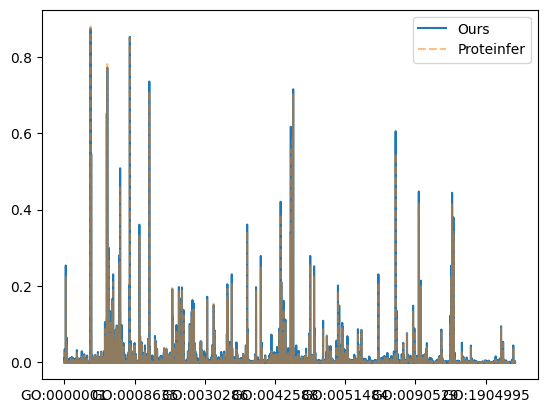

In [24]:
val_probabilities.mean(axis=0).plot(label='Ours')
pinf_val_probabilities.mean(axis=0).plot(label='Proteinfer',alpha=0.5,linestyle='--')
plt.legend()

In [25]:
pd.DataFrame(val_probabilities.mean(axis=0)).corrwith(pd.DataFrame(pinf_val_probabilities.mean(axis=0)),axis=0)

0    0.995114
dtype: float64

In [26]:
sequence_dist_corr = pinf_val_probabilities.corrwith(val_probabilities,axis=1)
label_dist_corr = pinf_val_probabilities.corrwith(val_probabilities,axis=0)

<Axes: >

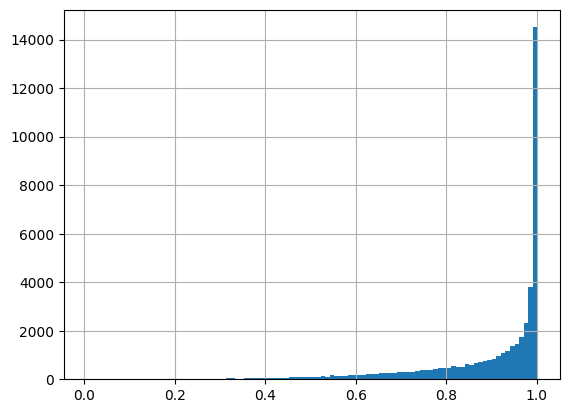

In [27]:
sequence_dist_corr.hist(bins=100)

<Axes: >

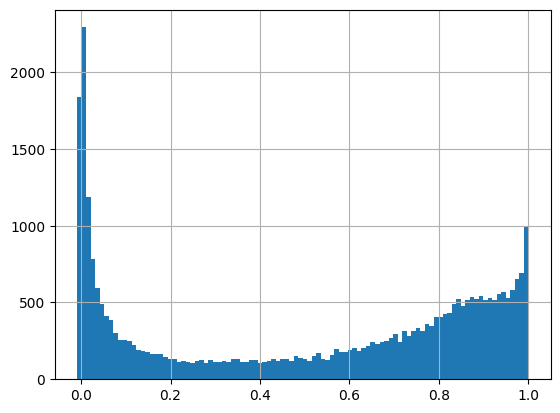

In [28]:
label_dist_corr.hist(bins=100)

Compare losses

In [19]:
bce_probs = torch.nn.BCELoss(reduction='none')
bce = torch.nn.BCEWithLogitsLoss(reduction='none')
fl = FocalLoss(alpha=-1,gamma=2,reduction='none')


Focal Loss with alpha: -1, gamma: 2, reduction: none, label_smoothing: 0.0


In [31]:
#BCE Loss
ours_val_bce_losses = bce(torch.tensor(val_logits.values), torch.tensor(val_labels.values).float())
pinf_val_bce_losses = bce(torch.tensor(pinf_val_logits.values), torch.tensor(pinf_val_labels.values).float())
pinf_val_bce_losses.mean(),ours_val_bce_losses.mean()

(tensor(0.0036), tensor(0.0020))

In [20]:
#Focal Loss

ours_val_fl_losses = fl(torch.tensor(val_logits.values), torch.tensor(val_labels.values).float())
pinf_val_fl_losses = fl(torch.tensor(pinf_val_logits.values), torch.tensor(pinf_val_labels.values).float())
pinf_val_fl_losses.mean(),ours_val_fl_losses.mean()

(tensor(0.0035), tensor(0.0008))

Random model baseline losses

In [21]:
random_model_bce = bce_probs(torch.ones_like(val_labels_t)*0.5, val_labels_t)
random_model_fl =fl(torch.ones_like(val_labels_t)*0.5, val_labels_t)
random_model_bce.mean(),random_model_fl.mean()

(tensor(0.6931), tensor(0.3769))

Always predict 1/672 = probability of positive in the dataset

In [22]:
always_negative_preds = torch.ones_like(val_labels_t)/672
predict_0_model_bce = bce_probs(always_negative_preds, val_labels_t)
predict_0_model_fl = fl(always_negative_preds, val_labels_t)

predict_0_model_bce.mean(),predict_0_model_fl.mean()


(tensor(0.0113), tensor(0.1737))

In [23]:
always_negative_preds = torch.ones_like(val_labels_t)/672
always_random = torch.ones_like(val_labels_t)*.5

Baseline top classes

In [24]:
n = 1000
predict_top_classes = val_probabilities.copy()
top_n = go_term_distribution[:n].index
predict_top_classes.iloc[:,:] = 0.0
for col in top_n:
    predict_top_classes[col]=0.9
predict_top_classes = torch.tensor(predict_top_classes.values).float()

predict_top_classes_bce = bce_probs(predict_top_classes, val_labels_t)
predict_top_classes_fl = fl(predict_top_classes, val_labels_t)

predict_top_classes_bce.mean(),predict_top_classes_fl.mean()

(tensor(0.0927), tensor(0.1867))

Calculate metrics per class for both model_comparison_auprc_per_label

In [25]:
#Define threshold to calculate threshold-dependent metrics otherwise only threshold-agnostic metrics are calculated
threshold = None
res=metrics_per_label_df(val_labels,val_probabilities,device='cuda',threshold=threshold)
pinf_res=metrics_per_label_df(pinf_val_labels,pinf_val_probabilities,device='cuda',threshold=threshold)


#Combine both dataframes
res['model']='Ours'
pinf_res['model']='Proteinfer'
res=pd.concat([res,pinf_res],axis=0)
res = res.drop(["Frequency","Relative Frequency"],axis=1)
res["Frequency"] = res.index.map(go_term_distribution)
res.to_parquet("model_comparison_auprc_per_label.parquet")

100%|██████████| 21791/21791 [00:50<00:00, 427.90it/s]
/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [26]:
res.groupby(['model']).mean()

,AUPRC,Frequency
model,,
Ours,0.592565,635.987821
Proteinfer,0.651608,635.987821


Visualie distribution of AUPRC

<Axes: xlabel='AUPRC', ylabel='Count'>

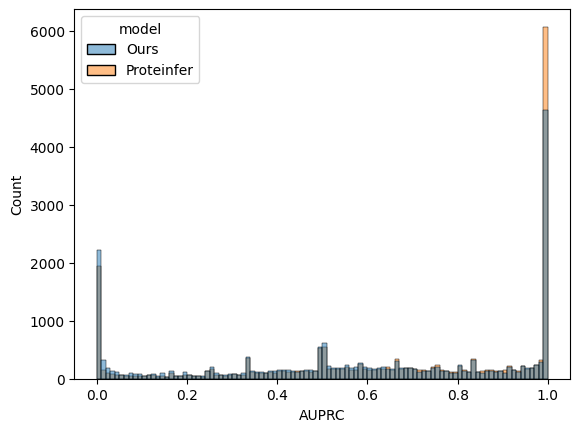

In [41]:
sns.histplot(data = res.reset_index(),x='AUPRC',hue='model',bins=100)

In [27]:
res_pivot = res.pivot(columns=['model'],values=['AUPRC','Frequency'])
res_pivot.columns = [i[0]+'_'+i[1] for i in res_pivot.columns]
ours_better = res_pivot[res_pivot['AUPRC_Ours']>res_pivot['AUPRC_Proteinfer']].sort_values(by='Frequency_Ours',ascending=False)

In [44]:
import gc
gc.collect()
torch.cuda.empty_cache()


23.943886497688506
8.06631595727722
8.305435995536426
9.995217599234817
10.004782400765183
9.749721026622032
9.947393591582975
10.007970667941974
9.979276263350869


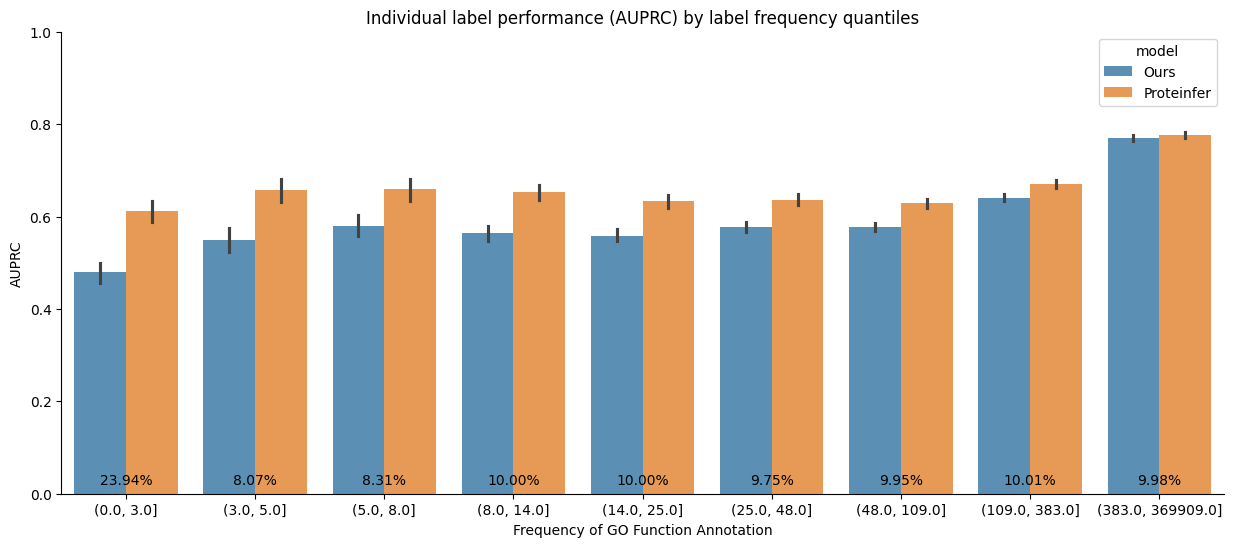

In [28]:
metric = 'AUPRC'
quantiles = 10 #May not find desired number and could be less.

#Bin frequencies
freq_bins, freq_bin_edges = pd.qcut(go_term_distribution,q=quantiles,duplicates='drop',precision=0,retbins=True, labels=None)

res['Frequency Bin']=res.index.map(freq_bins)
res.dropna(subset=["AUPRC"],inplace=True)
freq_bins_pct = freq_bins.value_counts()*100/len(go_term_distribution)
fig, ax = plt.subplots(figsize=(15,6))

# Annotate bars with the percentage of observations
for index, value in enumerate(freq_bins_pct.sort_index().values):
    print(value)
    ax.text(index, ax.get_ylim()[1]*0.01 + max(res[metric]) * 0.01, f"{value:.2f}%", ha='center')


sns.barplot(data = res.reset_index(drop=True),
            x='Frequency Bin',
            y=metric,
            alpha=0.8,
            errorbar=('ci', 95),
            hue='model')
ax.set(title=f'Individual label performance ({metric}) by label frequency quantiles',
       xlabel='Frequency of GO Function Annotation',
       ylabel=metric)
sns.despine()
plt.ylim(0,1)
plt.show()

In [29]:
res_ours = res.loc[res['model']=='Ours']
res_pinf = res.loc[res['model']=='Proteinfer']

res_ours[res_ours['AUPRC']>=0.9].sort_values(by='Frequency',ascending=False)

,AUPRC,model,Frequency,Frequency Bin
GO:0003674,0.996428,Ours,369909.0,"(383.0, 369909.0]"
GO:0008150,0.989658,Ours,346677.0,"(383.0, 369909.0]"
GO:0005575,0.993896,Ours,321980.0,"(383.0, 369909.0]"
GO:0009987,0.984949,Ours,295442.0,"(383.0, 369909.0]"
GO:0044464,0.988314,Ours,291432.0,"(383.0, 369909.0]"
...,...,...,...,...
GO:0033400,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0120012,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0035589,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0050643,1.000000,Ours,NaN,NaN


In [43]:
res_ours[res_ours['AUPRC']>=0.9][['AUPRC','Frequency']].mean()

AUPRC           0.966465
Frequency    8255.058458
dtype: float64

In [44]:
res_pinf[res_pinf['AUPRC']>=0.9].sort_values(by='Frequency',ascending=False)

,AUPRC,model,Frequency,Frequency Bin
GO:0003674,0.994481,Proteinfer,369909.0,"(383.0, 369909.0]"
GO:0008150,0.983664,Proteinfer,346677.0,"(383.0, 369909.0]"
GO:0005575,0.992867,Proteinfer,321980.0,"(383.0, 369909.0]"
GO:0009987,0.980420,Proteinfer,295442.0,"(383.0, 369909.0]"
GO:0044464,0.986555,Proteinfer,291432.0,"(383.0, 369909.0]"
...,...,...,...,...
GO:1904025,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0033841,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0090425,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0021837,1.000000,Proteinfer,1.0,"(0.0, 3.0]"


In [45]:
res_pinf[res_pinf['AUPRC']>=0.9][['AUPRC','Frequency']].mean()

AUPRC           0.988498
Frequency    1798.803335
dtype: float64

In [109]:
res_pinf.loc[res_ours[res_ours['AUPRC']>=0.8].index]['AUPRC'].mean()

0.9623318579385053

Explore worst errors

In [67]:
ours_val_fl_losses.shape

torch.Size([44300, 32102])

In [30]:
ours_val_fl_df = pd.DataFrame(ours_val_fl_losses.numpy(),index=val_labels.index,columns=val_labels.columns)

In [70]:
ours_val_fl_df

,GO:0000001,GO:0000002,GO:0000003,GO:0000006,GO:0000007,GO:0000009,GO:0000010,GO:0000011,GO:0000012,GO:0000014,...,GO:2001305,GO:2001306,GO:2001307,GO:2001308,GO:2001310,GO:2001311,GO:2001313,GO:2001315,GO:2001316,GO:2001317
Q6AF49,0.000000e+00,0.000000e+00,1.154452e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.228224e-09,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
Q9MS73,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A5FYS5,0.000000e+00,7.903817e-17,1.694066e-21,0.000000e+00,0.000000e+00,5.867545e-09,1.004901e-16,0.000000e+00,2.509816e-15,1.614107e-14,...,1.459441e-14,0.0,1.873496e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A5G348,2.927344e-18,1.300163e-08,3.881737e-10,6.323040e-16,1.598267e-05,2.395686e-13,0.000000e+00,8.924287e-15,6.674357e-09,1.039228e-11,...,1.543713e-16,0.0,1.355253e-20,1.972197e-12,3.237299e-13,0.000000e+00,5.810643e-19,3.659181e-19,1.694066e-21,0.0
Q5WFY4,0.000000e+00,1.731027e-14,8.238461e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.615977e-11,5.326664e-16,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q589A6,2.305630e-11,1.028675e-07,8.575885e-07,0.000000e+00,1.694066e-21,1.904007e-14,0.000000e+00,5.551105e-17,3.641385e-05,1.457440e-09,...,1.745387e-15,0.0,3.721860e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A9M9U0,0.000000e+00,1.355253e-20,5.326664e-16,0.000000e+00,0.000000e+00,0.000000e+00,3.659181e-19,0.000000e+00,0.000000e+00,0.000000e+00,...,2.220794e-13,0.0,1.161958e-17,4.573977e-20,1.694066e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A4IQ63,0.000000e+00,0.000000e+00,3.116989e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.305314e-16,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
Q0SYD4,0.000000e+00,1.694066e-21,2.818410e-13,0.000000e+00,0.000000e+00,1.694066e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.254800e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [75]:
loss_by_label = pd.concat([ours_val_fl_df.agg(['mean','median'],axis=0).T,
    label_descriptions,
    res[res['model']=='Ours'].drop(['model'],axis=1)],axis=1).dropna()

loss_by_sequence = ours_val_fl_df.agg(['mean','median'],axis=1).dropna()

In [101]:
for idx,row in loss_by_label.sort_values(by='mean',ascending=False).iloc[:10].iterrows():
    print(idx,row['label'])
    print('\n-----------')

GO:0043226 organized structure of distinctive morphology and function. includes the nucleus, mitochondria, plastids, vacuoles, vesicles, ribosomes and the cytoskeleton, and prokaryotic structures such as anammoxosomes and pirellulosomes. excludes the plasma membrane.

-----------
GO:0044444 any constituent part of the cytoplasm, all of the contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures.

-----------
GO:0043229 organized structure of distinctive morphology and function, occurring within the cell. includes the nucleus, mitochondria, plastids, vacuoles, vesicles, ribosomes and the cytoskeleton. excludes the plasma membrane.

-----------
GO:0043227 organized structure of distinctive morphology and function, bounded by a single or double lipid bilayer membrane. includes the nucleus, mitochondria, plastids, vacuoles, and vesicles. excludes the plasma membrane.

-----------
GO:0009987 any process that is carried out at the cellular lev

In [80]:
loss_by_sequence.sort_values(by='mean')

,mean,median
Q5FUG0,1.502230e-11,0.000000e+00
Q602S0,7.422003e-11,0.000000e+00
Q1MND4,7.841468e-11,0.000000e+00
Q5FUM8,1.432559e-10,0.000000e+00
Q2L066,1.630592e-10,0.000000e+00
...,...,...
B2RWS6,6.181519e-02,0.000000e+00
Q9NFU0,6.340533e-02,0.000000e+00
P84025,8.545986e-02,0.000000e+00
Q5NTH0,1.013311e-01,1.355253e-20


In [90]:
(loss_by_sequence['mean']>0.001).sum()

7189

In [91]:
loss_by_sequence.shape

(44300, 2)

<Axes: >

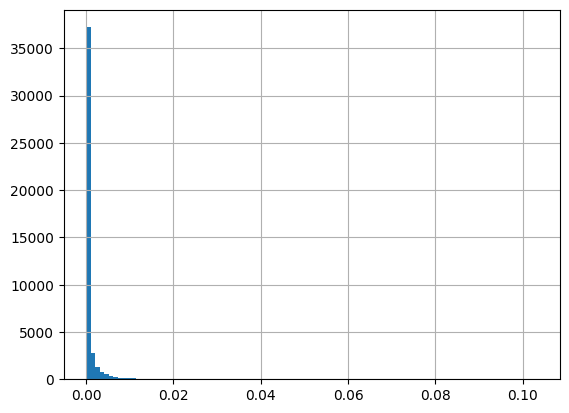

In [83]:
loss_by_sequence['mean'].hist(bins=100)

In [74]:
loss_by_label['mean'].describe()

count    2.143000e+04
mean     1.219555e-03
std      4.666291e-03
min      7.248066e-13
25%      4.160796e-05
50%      2.115680e-04
75%      6.974551e-04
max      9.733576e-02
Name: mean, dtype: float64

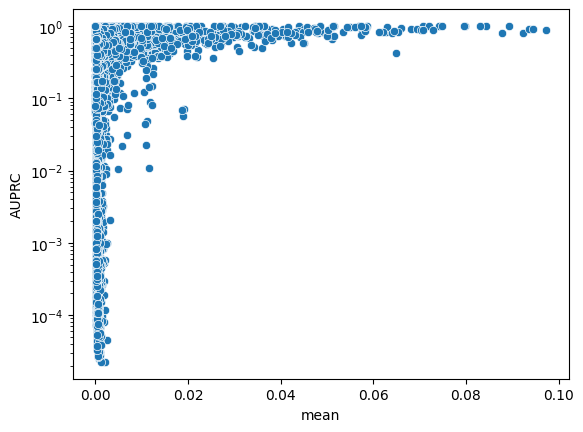

In [32]:
sns.scatterplot(data=loss_by_label,x='mean',y='AUPRC')
plt.yscale('log')

In [33]:
loss_by_label.sort_values(by='AUPRC',ascending=True)

,mean,median,label,AUPRC,Frequency,Frequency Bin
GO:0018894,2.107442e-03,0.000000e+00,the chemical reactions and pathways involving ...,0.000023,18.0,"(14.0, 25.0]"
GO:0033195,1.297307e-03,1.694066e-21,any process that results in a change in state ...,0.000023,1.0,"(0.0, 3.0]"
GO:0021794,8.668663e-04,0.000000e+00,the process in which the thalamus changes over...,0.000025,32.0,"(25.0, 48.0]"
GO:0035805,6.822970e-04,1.694066e-21,a specialized extracellular matrix that surrou...,0.000027,4.0,"(3.0, 5.0]"
GO:0051882,5.146728e-04,6.087953e-17,the process in which the potential difference ...,0.000027,8.0,"(5.0, 8.0]"
...,...,...,...,...,...,...
GO:0098951,2.532424e-07,0.000000e+00,the component of the postsynaptic recycling en...,1.000000,5.0,"(3.0, 5.0]"
GO:0098949,1.681292e-07,0.000000e+00,the component of the postsynaptic endosome mem...,1.000000,5.0,"(3.0, 5.0]"
GO:0009045,7.652585e-06,0.000000e+00,catalysis of the reaction: d-xylose = d-xylulose.,1.000000,157.0,"(109.0, 383.0]"
GO:0061673,8.529397e-06,0.000000e+00,any of the mitotic spindle microtubules that r...,1.000000,19.0,"(14.0, 25.0]"


In [34]:
loss_by_label.groupby('Frequency Bin')[['mean','median','AUPRC']].mean()

/tmp/ipykernel_2854353/1542846960.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_by_label.groupby('Frequency Bin')[['mean','median','AUPRC']].mean()


,mean,median,AUPRC
Frequency Bin,,,
"(0.0, 3.0]",0.000147,2.385207e-16,0.478933
"(3.0, 5.0]",0.000132,1.677594e-16,0.548990
"(5.0, 8.0]",0.000120,1.380560e-14,0.578740
"(8.0, 14.0]",0.000142,9.842679e-15,0.564338
"(14.0, 25.0]",0.000180,1.431132e-13,0.558794
"(25.0, 48.0]",0.000246,1.742332e-11,0.576597
"(48.0, 109.0]",0.000444,1.105453e-11,0.577686
"(109.0, 383.0]",0.000913,1.018724e-11,0.640943
"(383.0, 369909.0]",0.006323,2.650965e-07,0.769790


In [35]:
loss_by_label[['Frequency','AUPRC']].corr()

,Frequency,AUPRC
Frequency,1.000000,0.090163
AUPRC,0.090163,1.000000


In [36]:
ours_val_fl_df_melt = ours_val_fl_df.melt(ignore_index=False,var_name='label',value_name='mean_loss')

In [38]:
ours_val_fl_df_melt = ours_val_fl_df_melt.sort_values(by='mean_loss',ascending=False)

In [45]:
ours_val_fl_df_melt.head(100000).index.value_counts()

P84025    288
Q9D906    255
P0DJG1    253
P62979    250
P42160    235
         ... 
B0BNG2      1
Q86WD7      1
P14480      1
Q80XF7      1
Q9PLP9      1
Name: count, Length: 7766, dtype: int64

In [52]:
ours_val_fl_df.loc['P0DJG1'].sort_values()

GO:0000001     0.000000
GO:0060366     0.000000
GO:0060365     0.000000
GO:0060364     0.000000
GO:0060363     0.000000
                ...    
GO:0010811    11.202832
GO:0010720    11.820147
GO:1900024    13.609342
GO:0010770    14.351546
GO:1900026    15.171867
Name: P0DJG1, Length: 32102, dtype: float32

In [53]:
val_labels.loc['P0DJG1'].sort_values().sum()

33

In [61]:
train_unrepresented_labels = set(val_labels.columns) - set(go_term_distribution.index)

In [ ]:
train_unrepresented_labels

In [69]:
loss_by_label.shape

(21430, 6)

In [68]:
loss_by_label.loc[list(train_unrepresented_labels)]

KeyError: "None of [Index(['GO:0052231', 'GO:0046595', 'GO:0052191', 'GO:1903040', 'GO:0018530',\n       'GO:1905306', 'GO:0042848', 'GO:0051470', 'GO:0097627', 'GO:1990596',\n       ...\n       'GO:0031774', 'GO:0072552', 'GO:0030772', 'GO:0044619', 'GO:2001194',\n       'GO:0052371', 'GO:1900000', 'GO:0033820', 'GO:0060858', 'GO:0080185'],\n      dtype='object', length=737)] are in the [index]"

Other stuff

In [55]:


ground_truth = torch.tensor(val_labels.values)
preds = torch.tensor(val_probabilities.values)
sp = AveragePrecision(task="multilabel",num_labels=val_labels.shape[-1],average='macro').to('cuda')(preds,ground_truth).item()

ground_truth = torch.tensor(val_labels[items].values)
preds = torch.tensor(val_probabilities[items].values)
APMicro = AveragePrecision(task="multilabel",num_labels=len(items),average='micro').to('cuda')(preds,ground_truth).item()

/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
